## Cloud and Sea Classification




### mount the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
nc_dir = '/content/drive/MyDrive/dataset/'

Mounted at /content/drive


### combine all datasets into the numpy file, convert nc to npy


In [ ]:
!pip install netCDF4 basemap

In [ ]:
# -*- coding: utf-8 -*-
from netCDF4 import Dataset
import numpy as np
import sys
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from pandas import DataFrame
import os


def nc2npy(path):
    nc = Dataset(path)
    print(nc)
    nc = nc.variables[path.split('/')[-1].replace('.nc', '')]
    nc = np.array(nc)
    if 'unc' in path:
        nc[np.where(nc == 255)] = 0
    else:
        nc[np.where(nc == 65535)] = 0


    print(nc.max(), nc.min(), nc.mean())

    return nc


def main():
    for subset in ["radiance"]:
        res = []
        for i in range(1,22):
            arr = nc2npy(nc_dir+("Oa%02d_%s.nc"%(i,subset)))
            res.append(arr)
            plt.imsave("Oa%02d_radiance_unc.jpg"%i, arr)
            # plt.show()

        res = np.stack(res, axis=-1)
        print(res.shape)
        os.chdir('/content/drive/MyDrive/dataset')
        np.save("%s.npy"%subset, res)
        print("save successfully!")


main()


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    absolute_orbit_number: 16685
    ac_subsampling_factor: 16
    al_subsampling_factor: 1
    comment:  
    contact: eosupport@copernicus.esa.int
    creation_time: 2019-05-03T01:52:47Z
    history:   2019-05-03T01:52:47Z: PUGCoreProcessor /data/ipf-s3/workdir32/596242000/JobOrder.596242000.xml
    institution: LN1
    netCDF_version: 4.2 of Mar 13 2018 10:14:33 $
    product_name: S3A_OL_1_ERR____20190501T205354_20190501T213814_20190503T015247_2660_044_157______LN1_O_NT_002.SEN3
    references: S3IPF PDS 004.1 - i2r2 - Product Data Format Specification - OLCI Level 1, S3IPF PDS 002 - i1r7 - Product Data Format Specification - Product Structures, S3IPF DPM 002 - i2r1 - Detailed Processing Model - OLCI Level 1
    resolution: [ 1080 1176 ]
    source: IPF-OL-1-EO 06.08
    start_time: 2019-05-01T20:53:53.900798Z
    stop_time: 2019-05-01T21:38:14.215518Z
    title: OLCI Level 1b Product, Radiance Oa

### split the dataset into different five chunks through the nc files

In [ ]:
import os
import netCDF4
import numpy as np
import re



def split_npy(data, num_splits, save_dir, prefix='chunk'):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    chunks = np.array_split(data, num_splits, axis=0)


    for i, chunk in enumerate(chunks):
        save_path = os.path.join(save_dir, f"{prefix}_{i+1}.npy")
        np.save(save_path, chunk)
        print(f"Saved chunk {i+1} to {save_path}")

data = np.load('radiance.npy')


split_npy(data, num_splits=5, save_dir='/content/drive/MyDrive/dataset', prefix='chunk')


Saved chunk 1 to /content/drive/MyDrive/dataset/chunk_1.npy
Saved chunk 2 to /content/drive/MyDrive/dataset/chunk_2.npy
Saved chunk 3 to /content/drive/MyDrive/dataset/chunk_3.npy
Saved chunk 4 to /content/drive/MyDrive/dataset/chunk_4.npy
Saved chunk 5 to /content/drive/MyDrive/dataset/chunk_5.npy


Data shape: (15116, 1217, 21)
Chunk 1 shape: (3024, 1217, 21)


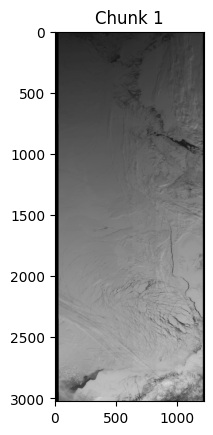

Chunk 2 shape: (3023, 1217, 21)


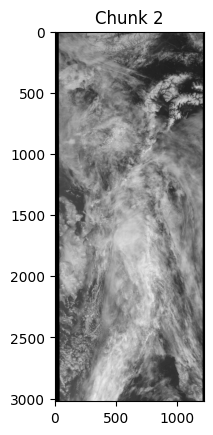

Chunk 3 shape: (3023, 1217, 21)


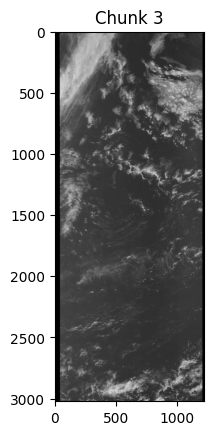

Chunk 4 shape: (3023, 1217, 21)


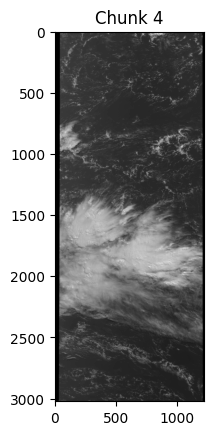

Chunk 5 shape: (3023, 1217, 21)


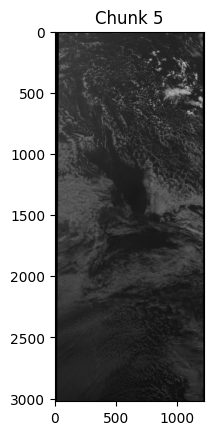

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

file_dir = '/content/drive/MyDrive/dataset/'
os.chdir(file_dir)

# load data
data = np.load('radiance.npy')

print(f"Data shape: {data.shape}")

# split data into 5 chunks
chunks = np.array_split(data, 5, axis=0)

for i, chunk in enumerate(chunks):
    print(f'Chunk {i+1} shape: {chunk.shape}')
    plt.imshow(chunk[:, :, 0], cmap='gray')  #
    plt.title(f'Chunk {i+1}')
    plt.show()


### Generate train data and test data by chunk4

In [ ]:
# Import all packages needed
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# Specify your path to files
datadir = '/content/drive/MyDrive/dataset'

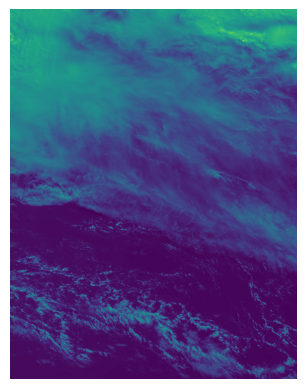

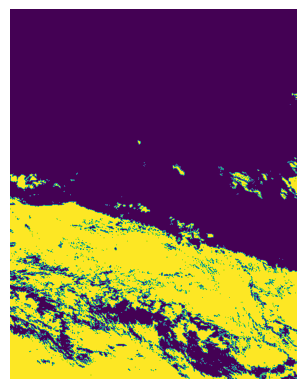

(793, 615)
(793, 615, 21)
(484883, 3, 3, 21)
(484883,)
{0: 326986, 1: 157897}
{0: 6802, 1: 142127}


In [ ]:
# The images are in numpy array format
image = np.load(datadir+ '/chunk_4.npy')

# Extracting the mask_area values from the JSON
x1, y1, x2, y2 = [283,1932,898,2725]

# Extracting the region of interest (ROI) from the image
roi = image[y1:y2, x1:x2]
# Now also read in the mask file
mask = cv2.imread('/content/drive/MyDrive/dataset/mask.png', cv2.IMREAD_UNCHANGED)


# Because the mask file is in RGB which has 3 channels, so we should convert it into binary mask as array with only 0 and 1 values
# binary_mask = np.where(mask[:,:,0] == 0, 1, 0)
binary_mask = np.where(mask[:,:,2] == 0, 1, 0)
# Extract channels 1, 2, and 3
channel_1 = roi[:,:,4]  # 0-based indexing for the first channel
rgb_image = np.stack([channel_1], axis=-1) # You can add more channels if you want

# Plotting the RGB image and you will see if it corresponds to the mask
plt.imshow(rgb_image)
plt.axis('off')
plt.show()
# You can also plot the mask
plt.imshow(binary_mask)
plt.axis('off')
plt.show()
## Another check needs to be done is their shape in first two dimensions
print(binary_mask.shape)
print(roi.shape)
# roi is your data with shape (300, 200, 21)
patches = []

# Iterate over the height and width of the roi, excluding the border pixels
for i in range(1, roi.shape[0] - 1):
    for j in range(1, roi.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = roi[i-1:i+2, j-1:j+2, :]
        patches.append(patch)

# Convert the list of patches to a numpy array
patches_array = np.array(patches)

print(patches_array.shape)
# Trim the mask to exclude boundary labels
trimmed_mask = binary_mask[1:-1, 1:-1]

# Flatten the trimmed mask to get a 1D array of labels
labels = trimmed_mask.flatten()

print(labels.shape)
# Assuming patches_array is your X and labels is your y
x_train, x_test, y_train, y_test = train_test_split(patches_array, labels, test_size=0.1, random_state=42)
# Initially, we examine the quantity of each class present in the dataset
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
# Identifying the class with the smaller count to balance the number in each class, for example, let it be 9396
num_class = 7580 # Adjust it to the amount you get
# Extract indices of both classes
indices_class_0 = np.where(labels == 0)[0]
indices_class_1 = np.where(labels == 1)[0]

# Randomly sample 9396 indices from class 0
sampled_indices_class_0 = np.random.choice(indices_class_0, num_class, replace=False)

# Combine the sampled indices with indices of class 1
combined_indices = np.concatenate([sampled_indices_class_0, indices_class_1])

# Extract the corresponding patches and labels
balanced_patches = patches_array[combined_indices]
balanced_labels = labels[combined_indices]


# Split the balanced dataset into training and testing sets with a 1:9 ratio
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    balanced_patches, balanced_labels, test_size=0.1, random_state=42
)

# Check the balance in y_train_balanced
unique, counts = np.unique(y_train_balanced, return_counts=True)
print(dict(zip(unique, counts)))



In [ ]:
import numpy as np
import os

os.chdir('/content/drive/MyDrive/dataset')
np.save ('X_train_balanced.npy',X_train_balanced)
np.save ('X_test_balanced.npy',X_test_balanced)
np.save ('y_train_balanced.npy',y_train_balanced)
np.save ('y_test_balanced.npy',y_test_balanced)

### Loading the data
From the previous jupyterbook, load my training and testing data ready from this code:

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
import os
import numpy as np

data_dir = '/content/drive/MyDrive/dataset/'
X_train = np.load(os.path.join(data_dir,'X_train_balanced.npy'))
X_test = np.load(os.path.join(data_dir, 'X_test_balanced.npy'))
y_train = np.load(os.path.join(data_dir,'y_train_balanced.npy'))
y_test = np.load(os.path.join(data_dir,'y_test_balanced.npy'))

print(X_train.shape)
print(y_train)

(148929, 3, 3, 21)
[1 1 1 ... 1 1 1]


### Convolutional Neural Networks (CNN)
CNN Code Implementation

In [ ]:
!pip install keras

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
data_dir = '/content/drive/MyDrive/dataset/'
# Define the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(3,3,21), padding='SAME'))
model.add(layers.MaxPooling2D((2, 2)))

channel = []
for _channel in range(0,21):
    channel.append(_channel)

# Add dense layers for classification
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))  # 10 is the number of classes

# Compile and train the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train[:,:,:,channel], y_train, epochs=4, validation_split=0.1)
loss, accuracy = model.evaluate(X_test[:,:,:,channel], y_test)
#model.fit(X_train, y_train, epochs=10, validation_split=0.1)
#loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')
model.save(data_dir + "/cnn.model")

Epoch 1/4
4189/4189 [==============================] - 30s 6ms/step - loss: 0.0471 - accuracy: 0.9913 - val_loss: 0.0302 - val_accuracy: 0.9919
Epoch 2/4
4189/4189 [==============================] - 25s 6ms/step - loss: 0.0159 - accuracy: 0.9950 - val_loss: 0.0145 - val_accuracy: 0.9952
Epoch 3/4
4189/4189 [==============================] - 22s 5ms/step - loss: 0.0141 - accuracy: 0.9956 - val_loss: 0.0090 - val_accuracy: 0.9968
Epoch 4/4
518/518 [==============================] - 2s 5ms/step - loss: 0.0108 - accuracy: 0.9959
Test accuracy: 0.995890736579895


In [ ]:
! ls/content/drive/MyDrive/dataset/cnn.model

/bin/bash: line 1: ls/content/drive/MyDrive/dataset/cnn.model: No such file or directory


In [ ]:
!pip install keras tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras import layers, models
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as sm
import pickle
import cv2

In [ ]:

def plot_image(map1, reverse=False):
  fig, ax = plt.subplots()
  cmap = ListedColormap(['white','black'])
  if reverse == True:
      cmap = ListedColormap(['black','white'])
  plt.imshow(map1, cmap=cmap, vmin=0, vmax=1)
  plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
  plt.axis('off')

(15116, 1217, 21)
(18363510, 3, 3, 4)


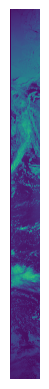

In [ ]:
x_test = []
# chunk = np.load(os.path.join('/content/drive/MyDrive/dataset','chunk_4.npy'))
chunk = np.load(os.path.join('/content/drive/MyDrive/dataset','radiance.npy'))


channel_1 = chunk[:,:,4]  # 0-based indexing for the first channel
rgb_image = np.stack([channel_1], axis=-1) # You can add more channels if you want
plt.axis('off')
# Plotting the RGB image and you will see if it corresponds to the mask
plt.imshow(rgb_image)
cv2.imwrite('/content/drive/MyDrive/dataset/chunk.png', rgb_image)

print(chunk.shape)
# Iterate over the height and width of the roi, excluding the border pixels
for i in range(1, chunk.shape[0] - 1):
    for j in range(1, chunk.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = chunk[i-1:i+2, j-1:j+2, :]
        x_test.append(patch)

# Convert the list of patches to a numpy array
x_test_21 = np.array(x_test)
x_test = x_test_21[...,[2,5,7,16]]
print(x_test.shape)

73455/73455 [==============================] - 106s 1ms/step


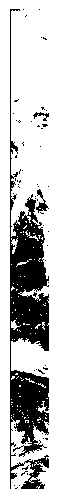

In [ ]:
# Make predictions on the full image

model = tf.keras.models.load_model('/content/drive/MyDrive/dataset/cnn.model')

# y_pred=model.predict(x_test_all, batch_size = 250)
y_pred=model.predict(x_test, batch_size = 250)
y_pred1 = np.argmax(y_pred,axis = 1)
map1=y_pred1.reshape(chunk.shape[0]-2, chunk.shape[1]-2)
plot_image(map1)

In [ ]:
cv2.imwrite('/content/drive/MyDrive/dataset/cnn-predict.png', np.where(map1 == 0, 1, 0) * 255)

True

### RF Model
RF Model Implementation

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as sm
import pickle
import numpy as np
# Initialise the model with n_estimators specifying the number of trees in the forest
clf = RandomForestClassifier(n_estimators=100)

# We need to reshape the data in order to be compatible with Random Forest
X_reshaped = np.reshape(X_train, (X_train.shape[0], -1))
# Fit the model to your training data
clf.fit(X_reshaped, y_train)

# Predict the classes of the test data
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], -1))
y_pred = clf.predict(X_test_reshaped)
print(sm.classification_report(y_test, y_pred))
pickle.dump(clf, open('/content/drive/MyDrive/dataset/rf_model.pkl', 'wb'))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       778
           1       1.00      1.00      1.00     15770

    accuracy                           1.00     16548
   macro avg       1.00      1.00      1.00     16548
weighted avg       1.00      1.00      1.00     16548



(18363510, 189)
(18363510,)


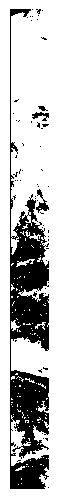

In [ ]:
model = pickle.load(open('/content/drive/MyDrive/dataset/rf_model.pkl', 'rb'))
x_test_rf = np.reshape(x_test_21, (x_test.shape[0], -1))
print(x_test_rf.shape)
y_pred1 = model.predict(x_test_rf)
print(y_pred1.shape)
map1=y_pred1.reshape(chunk.shape[0]-2, chunk.shape[1]-2)
plot_image(map1)

In [ ]:
cv2.imwrite('/content/drive/MyDrive/dataset/rf-predict.png', np.where(map1 == 0, 1, 0) * 255)

True

## Gaussian
Gaussian implementation

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
import os

data_dir = '/content/drive/MyDrive/dataset'
X_train = np.load(os.path.join(data_dir,'X_train_balanced.npy'))
X_test = np.load(os.path.join(data_dir, 'X_test_balanced.npy'))
y_train = np.load(os.path.join(data_dir,'y_train_balanced.npy'))
y_test = np.load(os.path.join(data_dir,'y_test_balanced.npy'))

# selected = [2, 5, 7, 16]

# (x, 3, 3, 21) -> (x, 9, 21)
X_train = X_train.reshape(-1, 9, 21)
X_test = X_test.reshape(-1, 9, 21)

# (x, 9, 21) -> (x, 9, 189)
X_train = X_train.reshape(-1, 189)
X_test = X_test.reshape(-1, 189)

print(X_train.shape)
print(y_train)

(148929, 189)
[1 1 1 ... 1 1 1]


In [ ]:
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics as sm

# Initialise Gaussian
gnb = GaussianNB()

# Fit the model to your training data
gnb.fit(X_train, y_train)

# Predict the classes of the test data
y_pred = gnb.predict(X_test)
print(sm.classification_report(y_test, y_pred))
pickle.dump(gnb, open('/content/drive/MyDrive/dataset/gaussian_model.pkl', 'wb'))

              precision    recall  f1-score   support

           0       0.55      0.97      0.70       778
           1       1.00      0.96      0.98     15770

    accuracy                           0.96     16548
   macro avg       0.78      0.97      0.84     16548
weighted avg       0.98      0.96      0.97     16548



(18363510, 189)
(18363510,)


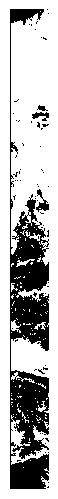

In [ ]:
model = pickle.load(open('/content/drive/MyDrive/dataset/gaussian_model.pkl', 'rb'))
x_test_rf = np.reshape(x_test_21, (x_test.shape[0], -1))
print(x_test_rf.shape)
y_pred1 = model.predict(x_test_rf)
print(y_pred1.shape)
map1=y_pred1.reshape(chunk.shape[0]-2, chunk.shape[1]-2)
plot_image(map1)

In [ ]:
cv2.imwrite('/content/drive/MyDrive/dataset/gaussian-predict.png', np.where(map1 == 0, 1, 0) * 255)

True

## GMM
GMM implementation

In [ ]:
from sklearn.mixture import GaussianMixture
import sklearn.metrics as sm
from sklearn.preprocessing import LabelEncoder

# Initialise Gaussian
gmm = GaussianMixture(n_components=2, random_state=42)

# Fit the model to your training data
gmm.fit(X_train, y_train)

# Predict the classes of the test data
y_pred = gmm.predict(X_test)

print(sm.classification_report(y_test, y_pred))
pickle.dump(gmm, open('/content/drive/MyDrive/dataset/gmm_model.pkl', 'wb'))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       778
           1       0.89      0.40      0.56     15770

    accuracy                           0.38     16548
   macro avg       0.45      0.20      0.28     16548
weighted avg       0.85      0.38      0.53     16548



(3671730, 189)
(3671730,)
(3670515, 189)
(3670515,)
(3670515, 189)
(3670515,)
(3670515, 189)
(3670515,)


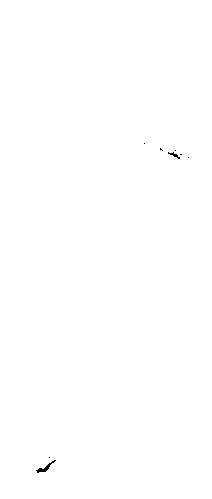

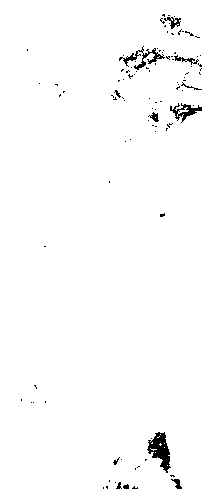

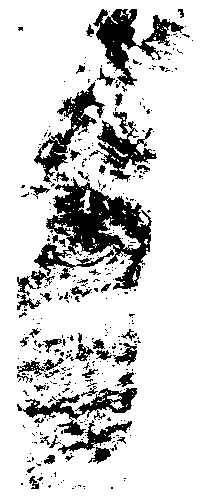

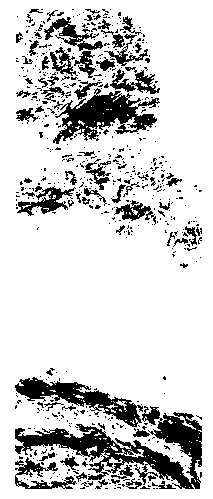

In [ ]:
model = pickle.load(open('/content/drive/MyDrive/dataset/gmm_model.pkl', 'rb'))

# run the model on each chunk since running
# the model on the full image will cause OOM
for i in range(1, 5):
  x_test = []
  chunk = np.load(os.path.join('/content/drive/MyDrive/dataset','chunk_' + str(i) +'.npy'))
  for i in range(1, chunk.shape[0] - 1):
    for j in range(1, chunk.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = chunk[i-1:i+2, j-1:j+2, :]
        x_test.append(patch)
  x_test = np.array(x_test)
  x_test = np.reshape(x_test, (x_test.shape[0], -1))
  print(x_test.shape)
  y_pred1 = model.predict(x_test)
  print(y_pred1.shape)
  map1=y_pred1.reshape(chunk.shape[0]-2, chunk.shape[1]-2)
  plot_image(map1, reverse=True)
  cv2.imwrite('/content/drive/MyDrive/dataset/gmm-predict-' + str(i) + '.png', map1 * 255)

## K-means

##K-means
K-means implementation

In [ ]:
from sklearn.cluster import KMeans
import sklearn.metrics as sm
from sklearn.preprocessing import LabelEncoder

# Initialise Gaussian
km = KMeans(n_clusters=2, random_state=42)

# Fit the model to your training data
km.fit(X_train, y_train)

# Predict the classes of the test data
y_pred = gmm.predict(X_test)

print(sm.classification_report(y_test, y_pred))
pickle.dump(km, open('/content/drive/MyDrive/dataset/kmeans.pkl', 'wb'))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       778
           1       0.89      0.40      0.56     15770

    accuracy                           0.38     16548
   macro avg       0.45      0.20      0.28     16548
weighted avg       0.85      0.38      0.53     16548



(18363510, 189)


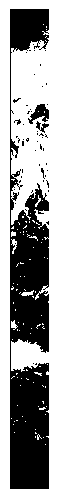

In [ ]:
model = pickle.load(open('/content/drive/MyDrive/dataset/kmeans.pkl', 'rb'))
x_test_rf = np.reshape(x_test_21, (x_test.shape[0], -1))
print(x_test_rf.shape)
y_pred1 = model.predict(x_test_rf)
map1=y_pred1.reshape(chunk.shape[0]-2, chunk.shape[1]-2)
plot_image(map1, reverse = True)

In [ ]:
cv2.imwrite('/content/drive/MyDrive/dataset/kmeans-predict.png', map1 * 255)

True

##  VIT
VIT Implementation

In [ ]:
data_dir = '/content/drive/MyDrive/dataset'
X_train = np.load(os.path.join(data_dir,'X_train_balanced.npy'))
X_test = np.load(os.path.join(data_dir, 'X_test_balanced.npy'))
y_train = np.load(os.path.join(data_dir,'y_train_balanced.npy'))
y_test = np.load(os.path.join(data_dir,'y_test_balanced.npy'))

In [ ]:
# Install packages needed
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report


def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = more_data(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=30,
        epochs=5,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [ ]:
num_classes = 2 #Can be changed to multi-classed classification
input_shape = (3, 3, 21)#depends on the size of the image we want

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [ ]:
# Data augmentation
more_data = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="more_data",
)
more_data.layers[0].adapt(X_train)

In [ ]:
# Here vit is your trained model after the training

vit = create_vit_classifier()

history = run_experiment(vit)

vit.save(data_dir + 'vit.model')

Epoch 1/5
4468/4468 [==============================] - 362s 79ms/step - loss: 0.0882 - accuracy: 0.9933 - top-5-accuracy: 1.0000 - val_loss: 0.0128 - val_accuracy: 0.9981 - val_top-5-accuracy: 1.0000
Epoch 2/5
4468/4468 [==============================] - 356s 80ms/step - loss: 0.0227 - accuracy: 0.9956 - top-5-accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 0.9983 - val_top-5-accuracy: 1.0000
Epoch 3/5
4468/4468 [==============================] - 355s 80ms/step - loss: 0.0168 - accuracy: 0.9961 - top-5-accuracy: 1.0000 - val_loss: 0.0119 - val_accuracy: 0.9983 - val_top-5-accuracy: 1.0000
Epoch 4/5
4468/4468 [==============================] - 354s 79ms/step - loss: 0.0135 - accuracy: 0.9969 - top-5-accuracy: 1.0000 - val_loss: 0.0181 - val_accuracy: 0.9973 - val_top-5-accuracy: 1.0000
Epoch 5/5
518/518 [==============================] - 16s 31ms/step - loss: 0.0134 - accuracy: 0.9979 - top-5-accuracy: 1.0000
Test accuracy: 99.79%
Test top 5 accuracy: 100.0%
successfully loaded


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


73455/73455 [==============================] - 2056s 28ms/step


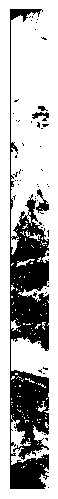

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)
model = tf.keras.models.load_model('/content/drive/MyDrive/dataset/vit.model', custom_objects={'Addons>AdamW': tfa.optimizers.AdamW})

# y_pred=model.predict(x_test_all, batch_size = 250)
y_pred=model.predict(x_test_21, batch_size = 250)
y_pred1 = np.argmax(y_pred,axis = 1)
map1=y_pred1.reshape(chunk.shape[0]-2, chunk.shape[1]-2)
plot_image(map1)

In [ ]:
cv2.imwrite('/content/drive/MyDrive/dataset/vit-predict.png', np.where(map1 == 0, 1, 0) * 255)

True